In [2]:
import pandas as pd
import os, types
import io, requests
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Import cleaned data

## Import west data

In [378]:
coast_electricity_weather_history = pd.read_csv('https://raw.githubusercontent.com/AmLunaW/datathon-code/Pouya/Cleaned%20Files_PS1/coast_electricity_weather_history.csv')
coast_df = coast_electricity_weather_history.drop(['index'], axis=1)
coast_df.shape
n_rows, n_cols = coast_df.shape

# Split to training and test sets

In [379]:
train_data= coast_df.iloc[:n_rows-30]
test_data = coast_df.iloc[-300:]

print(len(train_data), len(test_data))

113188 300


# Feature scaling

In [380]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(0,1))

## Scale west data

In [381]:
train_data_scaled = min_max_scaler.fit_transform(train_data)
train_data_scaled = pd.DataFrame(train_data_scaled)
train_data_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.406777,0.649485,0.125,0.0,0.690476,1.0,1.0,0.12,0.582609,0.808989,0.682243,0.136364,0.616,0.555556
1,0.386143,0.649485,0.125,0.0,0.690476,1.0,1.0,0.12,0.582609,0.808989,0.682243,0.136364,0.616,0.555556
2,0.374139,0.752577,0.125,0.0,0.500000,1.0,1.0,0.19,0.660870,0.831461,0.775701,0.060606,0.688,0.666667
3,0.373281,0.752577,0.125,0.0,0.500000,1.0,1.0,0.19,0.660870,0.831461,0.775701,0.060606,0.688,0.666667
4,0.391977,0.752577,0.125,0.0,0.500000,1.0,1.0,0.19,0.660870,0.831461,0.775701,0.060606,0.688,0.666667


In [382]:
test_data_scaled = min_max_scaler.fit_transform(test_data)
test_data_scaled = pd.DataFrame(test_data_scaled)
test_data_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.409084,0.678571,0.833333,0.131944,0.566038,0.833333,0.0,0.677778,0.633333,0.75,0.678571,0.714286,0.676471,0.0
1,0.442452,0.678571,0.833333,0.131944,0.566038,0.833333,0.0,0.677778,0.633333,0.75,0.678571,0.714286,0.676471,0.0
2,0.462216,0.678571,0.833333,0.131944,0.566038,0.833333,0.0,0.677778,0.633333,0.75,0.678571,0.714286,0.676471,0.0
3,0.497299,0.535714,0.833333,0.041667,0.735849,1.000000,0.0,0.688889,0.500000,0.75,0.535714,0.714286,0.558824,0.0
4,0.531103,0.535714,0.833333,0.041667,0.735849,1.000000,0.0,0.688889,0.500000,0.75,0.535714,0.714286,0.558824,0.0


### 3. Separate data into dependent and independent variables

#### 3.1 Pairwise plot

In [383]:
#import seaborn as sns

#sns.pairplot(train_data_scaled)

In [433]:
X_train = pd.DataFrame(train_data_scaled[[1,2,3,4,5,7,8,9,10,11,12,13]])
y_train = pd.DataFrame(train_data_scaled[0])

X_test = pd.DataFrame(test_data_scaled[[1,2,3,4,5,7,8,9,10,11,12,13]])
y_test = pd.DataFrame(test_data_scaled[0])

In [434]:
print(X_train.shape, y_train.shape,X_test.shape, y_test.shape )

(113188, 12) (113188, 1) (300, 12) (300, 1)


In [435]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
        if(i%10000==0):
            print('i = ',i)
            print('i + time_steps = ',i+time_steps)
        
    return np.array(Xs), np.array(ys)

In [436]:
time_steps = 24

X_train_steps, y_train_steps = create_dataset(X_train, y_train, time_steps)
print(X_train_steps.shape, y_train_steps.shape)

i =  0
i + time_steps =  24
i =  10000
i + time_steps =  10024
i =  20000
i + time_steps =  20024
i =  30000
i + time_steps =  30024
i =  40000
i + time_steps =  40024
i =  50000
i + time_steps =  50024
i =  60000
i + time_steps =  60024
i =  70000
i + time_steps =  70024
i =  80000
i + time_steps =  80024
i =  90000
i + time_steps =  90024
i =  100000
i + time_steps =  100024
i =  110000
i + time_steps =  110024
(113164, 24, 12) (113164, 1)


In [437]:
X_test_steps, y_test_steps = create_dataset(X_test, y_test, time_steps)
print(X_test.shape, y_test.shape)

i =  0
i + time_steps =  24
(300, 12) (300, 1)


In [438]:
print(X_test_steps.shape, y_test_steps.shape)

(276, 24, 12) (276, 1)


In [439]:
#print(X_test_steps.shape[2])

## 4. Use Tensorflow and Keras

In [440]:
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [486]:
model = Sequential()

model.add(LSTM(units=100,input_shape=(X_train_steps.shape[1], X_train_steps.shape[2])))

model.add(tf.keras.layers.Dense(units=1))
#model.add(Dropout(0.5))

model.compile(loss = root_mean_squared_error,
              optimizer=tf.keras.optimizers.Adam(0.001),
             )

model.summary()

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_59 (LSTM)               (None, 100)               45200     
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 101       
Total params: 45,301
Trainable params: 45,301
Non-trainable params: 0
_________________________________________________________________


In [487]:
tf.random.set_seed(1234)
history = model.fit(
    X_train_steps[len(X_train_steps)-500:len(X_train_steps),:], y_train_steps[len(y_train_steps)-500:len(y_train_steps)],
    epochs=33,
    batch_size=300,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Epoch 1/33
2/2 [==============================] - 2s 507ms/step - loss: 0.6290 - val_loss: 0.1778
Epoch 2/33
2/2 [==============================] - 0s 82ms/step - loss: 0.1509 - val_loss: 0.2979
Epoch 3/33
2/2 [==============================] - 0s 87ms/step - loss: 0.2834 - val_loss: 0.2058
Epoch 4/33
2/2 [==============================] - 0s 79ms/step - loss: 0.1796 - val_loss: 0.1250
Epoch 5/33
2/2 [==============================] - 0s 97ms/step - loss: 0.1261 - val_loss: 0.1791
Epoch 6/33
2/2 [==============================] - 0s 88ms/step - loss: 0.1614 - val_loss: 0.1599
Epoch 7/33
2/2 [==============================] - 0s 84ms/step - loss: 0.1313 - val_loss: 0.1165
Epoch 8/33
2/2 [==============================] - 0s 89ms/step - loss: 0.0968 - val_loss: 0.1353
Epoch 9/33
2/2 [==============================] - 0s 89ms/step - loss: 0.1290 - val_loss: 0.1462
Epoch 10/33
2/2 [==============================] - 0s 84ms/step - loss: 0.1367 - val_loss: 0.1210
Epoch 11/33
2/2 [===========

## Plot the training and validation accuracy and loss (root_mean_squared_error) at each epoch

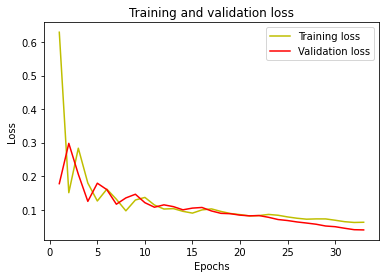

In [488]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [489]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# plt.plot(epochs, acc, 'y', label='Training acc')
# plt.plot(epochs, val_acc, 'r', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [490]:
predicted_electricity_load = model.predict(X_test_steps)

In [491]:
#print(predicted_electricity_load)

In [492]:
lenth = len(predicted_electricity_load)
print(lenth)

276


In [493]:
predicted_np = np.column_stack( (predicted_electricity_load , np.ones((lenth,13)) ))

In [494]:
print(predicted_np.shape)

(276, 14)


In [495]:
predicted_electricity_load_inverse = min_max_scaler.inverse_transform(predicted_np)

In [496]:
#predicted_electricity_load_inverse

In [497]:
actual_np = np.column_stack( (y_test_steps , np.ones((lenth,13)) ) )

In [498]:
actual_electricity_load_inverse = min_max_scaler.inverse_transform(actual_np)

In [499]:
#actual_electricity_load_inverse

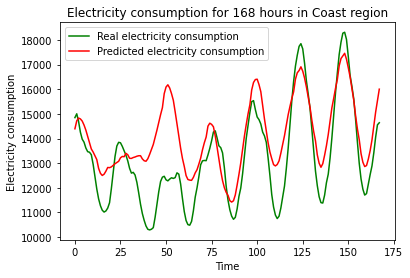

In [500]:
plt.plot(actual_electricity_load_inverse[0:168,0], color='green', label = 'Real electricity consumption')
plt.plot(predicted_electricity_load_inverse[0:168,0], color='red', label = 'Predicted electricity consumption')
plt.title('Electricity consumption for 168 hours in Coast region')
plt.xlabel('Time')
plt.ylabel('Electricity consumption')
plt.legend()
plt.show()